In [1]:
import pandas as pd

relacoes_entre_cnpjs = pd.read_csv(
    '/home/pedro/code/trabalho/M04/M04_2021/data/input/relacao_cnpjs.csv',
    header=None,
    dtype=str,
    sep=' '
)

informacoes_licitacoes = pd.read_csv(
    '/home/pedro/code/trabalho/M04/M04_2021/data/input/infos_licitacoes.csv',
    dtype=str,
    sep=';'
)

cnpjs_por_licitacao = pd.read_csv(
    '/home/pedro/code/trabalho/M04/M04_2021/data/input/licitacoes_cnpjs_licitantes.csv',
    dtype=str,
    sep=';'
)

# Encontrando cliques de cnpjs relacionados para municipios

### Vamos analisar as licitações em nível municipal

#### Começamos selecionando uma cidade:

In [2]:
cidades = informacoes_licitacoes['nom_entidade'].unique()
index_cidade_escolhida = list(cidades).index('Rio Pardo de Minas')

#### Escolhemos o município de Rio Pardo de Minas.

1. Selecionamos as licitações correspondentes ao município.

In [3]:
licitacoes_do_municipio = informacoes_licitacoes.loc[informacoes_licitacoes['nom_entidade'] == cidades[index_cidade_escolhida]]
licitacoes_do_municipio = licitacoes_do_municipio['seq_dim_licitacao']

2. Filtramos o arquivo de cnpjs licitantes pelas licitações do município.

In [4]:
cnpjs_licitantes = cnpjs_por_licitacao[cnpjs_por_licitacao['seq_dim_licitacao'].isin(licitacoes_do_municipio)]
cnpjs_licitantes = cnpjs_licitantes['num_documento']
cnpjs_licitantes

47548     02703578000130
47565     21656180000134
47570     18612228000106
47576     11060497000150
47579     18441956000194
               ...      
420625    03913793000128
420626    03054804000161
420627    28344054000193
420628    11757854000133
420629    16615921000107
Name: num_documento, Length: 756, dtype: object

#### 3. Criacao do grafo de CNPJs relacionados dentro do contexto municipal

In [6]:
import networkx as nx

G = nx.Graph()
# cnpjs_licitantes = cnpjs_licitantes.values


# deve existir uma forma mais inteligente de fazer isso usando funcoes nativas
for cnpj in cnpjs_licitantes:
    G.add_node(cnpj)
    relacoes_do_cnpj = relacoes_entre_cnpjs.loc[relacoes_entre_cnpjs[0] == cnpj]

    for relacao in relacoes_do_cnpj.values:
        if relacao[1] in cnpjs_licitantes.values:
            G.add_edge(relacao[0], relacao[1])

cliques = list(nx.find_cliques(G))
tamanho_cliques = [len(clique) for clique in cliques]
max(tamanho_cliques)

77

In [7]:
nx.density(G)

0.05470318200066328

- Rio Pardo de Minas foi escolhida por conter a maior max_clique no arquivo RELATORIO_GRAFOS_POR_MUNICIPIO.csv.

- O campo max_clique contem o valor de 77, aqui tambem. 

- Nao tenho certeza se a max clique seria somente a clique de tamanho maximo dentre as cliques do municipio, que e o que calculamos aqui.

- O valor de densidade retornado pela funcao **density** equivale ao valor de 0,0547031820006633 observado no relatorio.

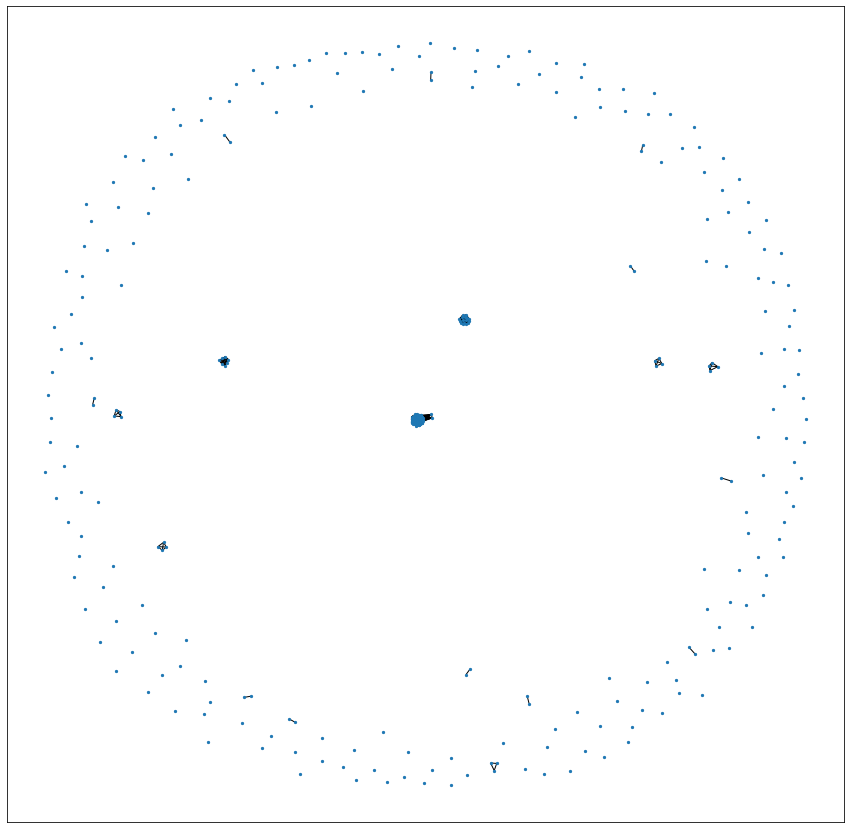

In [8]:
import matplotlib.pyplot as plt

def plota_grafo(grafo: nx.Graph) -> plt.figure:
    """Plota o grafo.
    """    
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(grafo)
    nx.draw_networkx_nodes(grafo, pos, node_size=5)
    nx.draw_networkx_edges(grafo, pos, width=1)
    plt.show()

plota_grafo(G)

In [11]:
def sumariza_licitacao(municipio: str):
    licitacoes_do_municipio = informacoes_licitacoes.loc[informacoes_licitacoes['nom_entidade'] == municipio]
    licitacoes_do_municipio = licitacoes_do_municipio['seq_dim_licitacao']
    
    cnpjs_licitantes = cnpjs_por_licitacao[cnpjs_por_licitacao['seq_dim_licitacao'].isin(licitacoes_do_municipio)]
    cnpjs_licitantes = cnpjs_licitantes['num_documento']

    G = nx.Graph()

    # deve existir uma forma mais inteligente de fazer isso usando funcoes nativas
    for cnpj in cnpjs_licitantes:
        G.add_node(cnpj)
        relacoes_do_cnpj = relacoes_entre_cnpjs.loc[relacoes_entre_cnpjs[0] == cnpj]

        for relacao in relacoes_do_cnpj.values:
            if relacao[1] in cnpjs_licitantes.values:
                G.add_edge(relacao[0], relacao[1])

    cliques = list(nx.find_cliques(G))
    tamanho_cliques = [len(clique) for clique in cliques]
    clique_max = max(tamanho_cliques)
    densidade = nx.density(G)
    arestas = G.number_of_edges()
    nodos = G.number_of_nodes()

    print('Analisando o municipio de ', municipio)
    print('Clique max:', clique_max)
    print('Densidade:', densidade)
    print('CNJPs relacionados:', arestas)
    print('CNPJs participantes:', nodos)    

In [14]:
sumariza_licitacao('Rio Pardo de Minas')

Analisando o municipio de  Rio Pardo de Minas
Clique max: 77
Densidade: 0.05470318200066328
CNJPs relacionados: 3134
CNPJs participantes: 339
